In [28]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
# Computational modules
import zarr
import dask
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import cartopy.crs as ccrs
import datetime
# Maps   
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray
import geopandas as gpd
from shapely.geometry import box, mapping
import dateutil
import pysolar
from cartopy.util import add_cyclic_point

#!{sys.executable} -m pip install --user cmip6_preprocessing
!{sys.executable} -m pip install --user nc-time-axis
# Local files and utility functions
sys.path.append("./subroutines/")
import pices
#!{sys.executable} -m pip install --user pytz
#!{sys.executable} -m pip install --user tzwhere
import pytz
#from tzwhere import tzwhere
#!{sys.executable} -m pip install --user astropy
#import astropy

import xesmf as xe
np.seterr(divide='ignore', invalid='ignore')
get_ipython().run_line_magic("matplotlib", "inline")
plt.rcParams["figure.figsize"] = 12, 6
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")

In [2]:
from dask.distributed import Client, progress
client = Client() 
client

Client Scheduler: tcp://127.0.0.1:38901 Dashboard: /user/trondkr/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 63.33 GB


In [3]:
class Config_pices():
    df = pd.read_csv(
    "https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv"
)
    fs = gcsfs.GCSFileSystem(token="anon", access="read_only")
   
    grid_labels = ["gn"]  # Can be gr=grid rotated, or gn=grid native
    member_ids = ["r1i1p1f1"]  #
    experiment_ids = ["ssp585"]  #'abrupt-4xCO2',
    source_ids = ["CanESM5"]
    variable_ids = ["uas","vas","tos"]
    table_ids = ["Amon","Amon","Omon"]  # Amon=atmospheric variables, Omon=Ocean variables, SImon=sea-ice variables
    dset_dict = {}
    start_date="1950-01-01"
    end_date="2100-08-01"
    clim_start="1961-01-01"
    clim_end="1990-01-01"
    
    selected_depth=0
  
# Create the object
config_pices_obj = Config_pices()
config_pices_obj = pices.get_and_organize_cmip6_data(config_pices_obj)

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='uas'

Running projections query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and member_id=='r1i1p1f1' and grid_label=='gn' and experiment_id=='ssp585' and variable_id=='uas'

CanESM5 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='vas'

Running projections query on data: 
 ==> source_id=='CanESM5'and table_id=='Amon' and member_id=='r1i1p1f1' and grid_label=='gn' and experiment_id=='ssp585' and variable_id=='vas'

CanESM5 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='CanESM5'and table_id=='Omon' and grid_label=='gn' and experiment_id=='historical' and variable_id=='tos'



In [4]:
# Following Roland Seferian, equation 3
# https://www.geosci-model-dev.net/11/321/2018/gmd-11-321-2018.pdf

def calculate_alpha_dir(n_lambda,µ):
    a = np.sqrt(1.0 - (1.0 - µ**2)/n_lambda**2)
    b = ((a-n_lambda*µ)/(a+n_lambda*µ))**2    
    c = ((µ-n_lambda*a)/(µ+n_lambda*a))**2

    return 0.5*(b+c)

In [5]:
def calculate_diffuse_reflection(n_λ,σ):
    return -0.1479 + 0.1502*n_λ-0.0176*n_λ*σ

In [6]:
def surface_roughness(µ, σ):
    # Surface roughness following Jin et al. 2014 equation 4
    # This rougness parameter determines the Fresnel refraction 
    # index from flat surface
    return (0.0152-1.7873*µ + 6.8972*(µ**2)-8.5778*(µ**3)+ 4.071*σ-7.6446*µ*σ) * np.exp(0.1643-7.8409*µ-3.5639*µ**2-2.3588*σ+10.054*µ*σ)

In [7]:
def calculate_direct_reflection(n_λ,µ,σ):
    µ = np.cos(np.radians(50.))
    # Direct reflection following Jin et al. 2014 equation 1
    f_0 = calculate_alpha_dir(1.34,µ)
    f_λ = calculate_alpha_dir(n_λ,µ)
    
    return f_λ - (surface_roughness(µ, σ)*f_λ/f_0)

In [8]:
def calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct):
   
    rw=0.48168549-0.014894708*σ-0.20703885*σ**2
 
    # Determine absorption and backscattering
    # coefficients to determine reflectance below the surface (Ro) once for all
    a_bp = 0.06*alpha_chl*chl**0.65 + 0.2*(0.00635+0.06*(chl**0.65))*np.exp(0.014*(440.-λ))
   
    # Backscattering of biological pigment (b_chl) with λ expressed here in nm and [Chl] in mg m−3. This
    # formulation is valid for [Chl] ranging between 0.02 and 2 mg m−3 (Morel and Maritorena (2001))
    # Equation 12 Roland Seferian, 2018
    b_chl=(0.416*chl**0.766)*(0.002+0.01*(0.5-0.25*np.log(chl))*(λ/550.0)**(0.5*(np.log(chl)-0.3)))
   
    # # Use Morel 91 formula to compute the direct reflectance below the surface (Morel-Gentili(1991), Eq (12))
    n=0.5*beta_w/(0.5*beta_w + b_chl)
   
    # Equation 11 Roland Seferian, 2018
    beta = 0.6279-0.2227*n-0.0513*n**2 +(0.2465*n - 0.3119)*µ
    
    # Equation 10 Roland Seferian, 2018
    R0 = beta * (0.5*beta_w + b_chl)/(alpha_w + a_bp)
   
    # Water leaving albedo, equation 8 Roland Seferian, 2018
    return (((1.0-rw)*R0)/(1-rw*R0))*(1-alpha_direct)

In [9]:
def calculate_diffuse_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct):
    #  In the case of ocean interior reflectance for direct incoming radiation it depends on µ = cos(θ) whereas in the
    # case of ocean interior reflectance for diffuse µ = 0.676. This value is considered an effective angle of incoming radiation of 47.47◦
    # according to Morel and Gentili (1991). Hence
    return calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, np.arccos(0.676), alpha_direct)

In [10]:
def whitecap(wind):
    # Whitecap effect as defined by Salisbury et al. 2014. NOTE that the value in paper is in percent
    # so we use the ratio instead (/100.) 
    # Salisbury, D. J., Anguelova, M. D., and Brooks, I. M.: Global Distribution and Seasonal 
    # Dependence of Satellite-based Whitecap Fraction
    #
    # Whitecaps are the surface manifestation of bubble plumes, created when 
    # surface gravity waves break and entrain air into the water column. 
    # They enhance air-sea exchange, introducing physical processes different from 
    # those operating at the bubble-free water surface. 

    return 0.000397*(np.exp(1.59*np.log(wind)))

In [32]:
def calculate_spectral_and_broadband_OSA(wind,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy):
    wc = whitecap(wind)
    OSA_direct = (alpha_direct + alpha_direct_chl) * (1-wc) + wc*alpha_wc
    OSA_diffuse = (alpha_diffuse + alpha_diffuse_chl) * (1-wc) + wc*alpha_wc
    
    # Integrate across all wavelengths 200-4000nm at 10 nm wavelength bands and then weight by the solar energy at each band
    OSA_direct_broadband = np.sum(OSA_direct*solar_energy)/np.sum(solar_energy)
    OSA_diffuse_broadband = np.sum(OSA_diffuse*solar_energy)/np.sum(solar_energy)
    return OSA_direct_broadband + OSA_diffuse_broadband
  #  print("calculate_spectral_and_broadband_OSA: {} {}".format(OSA_direct_broadband,OSA_diffuse_broadband))

In [12]:
def calculate_OSA(µ, uv, chl, wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy):
    
    # Solar zenith angle
   # µ = np.cos(np.radians(latitude))
    # wind is wind at 10 m height (m/s)
    σ = np.sqrt(0.003+0.00512*uv)
                
    # Vectorize the functions
    vec_calculate_direct_reflection=np.vectorize(calculate_direct_reflection)
    vec_calculate_diffuse_reflection=np.vectorize(calculate_diffuse_reflection)
    vec_calculate_direct_reflection_from_chl=np.vectorize(calculate_direct_reflection_from_chl)
    vec_calculate_diffuse_reflection_from_chl=np.vectorize(calculate_diffuse_reflection_from_chl)

    # Direct reflection
    alpha_direct = vec_calculate_direct_reflection(refractive_indexes,µ,σ)
   
    # Diffuse reflection
    alpha_diffuse = vec_calculate_diffuse_reflection(refractive_indexes,σ)

    # Reflection from chlorophyll and biological pigments
    alpha_direct_chl = vec_calculate_direct_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct)
   
    # Diffuse reflection interior of water from chlorophyll
    alpha_diffuse_chl = vec_calculate_diffuse_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct)

    # OSA
    return calculate_spectral_and_broadband_OSA(uv,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy)

In [13]:
def setup_parameters():
    df=pd.read_csv("data/Wavelength/Fresnels_refraction.csv", header=0, sep=";", decimal=",")
    wavelengths=df["λ"].values
    refractive_indexes=df["n(λ)"].values
    alpha_chl=df["a_chl(λ)"].values
    alpha_w=df["a_w(λ)"].values
    beta_w=df["b_w(λ)"].values
    alpha_wc=df["a_wc(λ)"].values
    solar_energy=df["E(λ)"].values
    return wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy

# Calculate solar zenith angle using pysolar
![zenith](images/solar_zenith.jpg)

In [14]:
def calculate_zenith_angle(lat, lon, month, hour_of_day):
    if (lon)>180: lon=lon-360.
    offset=(int(lon/15.)*3600)
    
    when = datetime.datetime(2006,month,15,hour_of_day,0,0,tzinfo=dateutil.tz.tzoffset(None, offset)).astimezone(pytz.UTC) 
    altitude_deg = pysolar.solar.get_altitude(lat, lon, when)
    
    if  altitude_deg <= 0 or altitude_deg > 180:
        zenith = 90
        cos_teta=0
        surface_light=0
    else:
        zenith = 90.0-altitude_deg

     #  surface_light = pysolar.radiation.get_radiation_direct(when, altitude_deg)
        cos_teta = np.cos(np.radians(zenith))
   # print("loc ({},{}) offset {} zenith {} cos_teta {} when {}".format(lat,lon,offset,zenith,cos_teta,when))
    return cos_teta

In [15]:
latitudes=[37.46,60.]
months=[m+3 for m in range(1)]
lon=-122
hour_of_day=12
for lat in latitudes:
    for month in months:
        cosT = calculate_zenith_angle(lat,lon,month,hour_of_day)
        print("Latitude: {} cosTeta: {} month: {}".format(lat,cosT,month+1))

Latitude: 37.46 cosTeta: 0.7706109488466542 month: 4
Latitude: 60.0 cosTeta: 0.46933292656725895 month: 4


=> model: uas_ssp585_gn_CanESM5_r1i1p1f1 variable name: uas
=> model: vas_ssp585_gn_CanESM5_r1i1p1f1 variable name: vas
Running for hour 15
Median albedo for  direct light 0.04039133251045608
Time to finish 0:01:00.099891 with mean OSA 0.040436654895251924


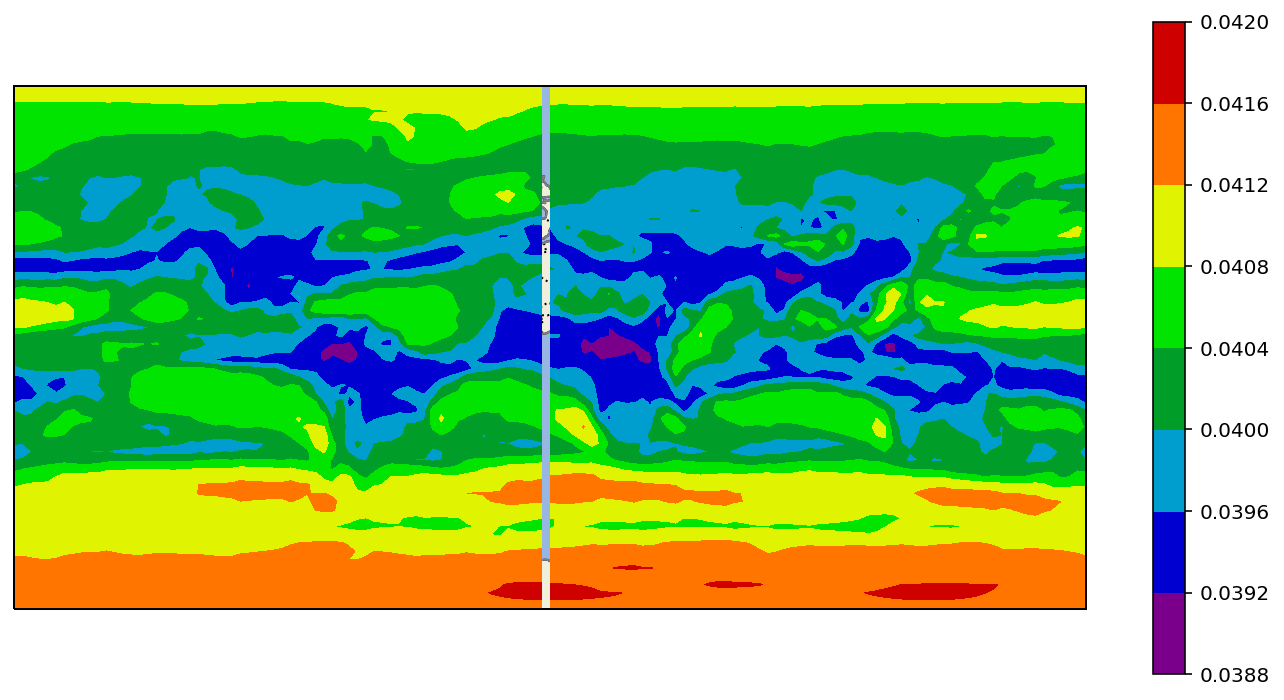

In [33]:
def calculate_light(config_pices_obj):
    
    #vec_calculate_insolation_weighted_zenith_angle=np.vectorize(calculate_insolation_weighted_zenith_angle)
    
    selected_time=0
    show_plot=False
    wavelengths, refractive_indexes, alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy = setup_parameters()
    startdate=datetime.datetime.now()
    
    for key in config_pices_obj.dset_dict.keys():
        
        var_name = key.split("_")[0]
        model_name = key.split("_")[3]
        
        if var_name=="uas":
            
            key_v="vas"+key[3:]
            key_tos="tos"+key[3:]
            var_name_v = key_v.split("_")[0]
            model_name_v = key_v.split("_")[3]
            
            print("=> model: {} variable name: {}".format(key, var_name))
            print("=> model: {} variable name: {}".format(key_v, var_name_v))
            
            if model_name_v==model_name:
                ds_uas=config_pices_obj.dset_dict[key]
               # ds_uas=ds_uas.sel(y=slice(0,90))
                ds_vas=config_pices_obj.dset_dict[key_v]
                ds_tos=config_pices_obj.dset_dict[key_tos]
              #  ds_vas=ds_vas.sel(y=slice(0,90))
                mask=ds_tos["tos"].isel(time=selected_time).values
                mask=np.ma.masked_invalid(mask)
                
              #  new_lon = np.linspace(0,360,1)
              #  new_lat = np.linspace(-90,90,1)
              
               # dsi_vas = ds_vas.interp(lat=new_lat, lon=new_lon)
               # dsi_uas = ds_uas.interp(lat=new_lat, lon=new_lon)
    
                # For a for a rectangular grid the cosine of the latitude is proportional to the grid cell area.
                area_ds_uas = ds_uas*np.cos(np.deg2rad(ds_uas["uas"].y))
                area_ds_vas = ds_vas*np.cos(np.deg2rad(ds_vas["vas"].y))
            
                proj=ccrs.PlateCarree() # ccrs.Orthographic(-10, 90)
                uv=(np.sqrt(area_ds_uas["uas"].isel(time=selected_time)**2+area_ds_vas["vas"].isel(time=selected_time)**2)/2.)
                if show_plot:
                    ax = plt.axes(projection=proj)
                    uv.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
                    ax.add_feature(cfeature.LAND)
                    ax.add_feature(cfeature.COASTLINE)
                    ax.set_global()
                    plt.show()
                
                wind=uv.values.T
                m=len(wind[:,0])
                n=len(wind[0,:])
                month=4
                    
                all_zens=[]
                all_OSA=[]
                for hour_of_day in range(15,16,1):
                    print("Running for hour {}".format(hour_of_day))
                    zen = [dask.delayed(calculate_zenith_angle)(uv.lat.values[i,j],
                                 uv.lon.values[i,j],month,hour_of_day)
                                 for i in range(m) 
                                  for j in range(n)]

                    zeniths = dask.compute(zen)
                    zens = np.asarray(zeniths).reshape((m, n))
                    
                    all_zens.append(zens)
                    
                    chl=0.2

                    zr = [dask.delayed(calculate_OSA)(zens[i,j], wind[i,j], chl, wavelengths, refractive_indexes, 
                                                    alpha_chl, alpha_w, beta_w, alpha_wc, solar_energy) 
                                  for i in range(m) 
                                  for j in range(n)]

                    z = dask.compute(zr)
                    print("Median albedo for  direct light {}".format(np.median(z)))

                    OSA_direct_broadband = np.array(z).reshape((m, n))
                    print("Time to finish {} with mean OSA {}".format(datetime.datetime.now()-startdate,
                          np.mean(OSA_direct_broadband)))
                    
                    all_OSA.append(OSA_direct_broadband)
                    
                
                zens=np.mean(np.asarray(all_zens),axis=0)
                OSA_direct_broadband=np.mean(np.asarray(all_OSA),axis=0)
                
             #   OSA_direct_broadband, lon = add_cyclic_point(OSA_direct_broadband, coord=uv.lon.values)
                
                ax3 = plt.axes(projection=proj)
                levels=np.arange(0,0.1,0.001)
                plt.contourf(uv.lon.values,uv.lat.values,OSA_direct_broadband,
                             transform=ccrs.PlateCarree(),
                             cmap='nipy_spectral',zorder=2)
               
                ax3.add_feature(cfeature.LAND)
                ax3.add_feature(cfeature.OCEAN)
                ax3.add_feature(cfeature.COASTLINE)
                ax3.add_feature(cfeature.BORDERS, linestyle=':')
                ax3.coastlines(color="grey") 
              #  ax2.set_extent([-160, 50, 5, 90])
                plt.colorbar()
                
                plt.show()


              
calculate_light(config_pices_obj)

In [ ]:
client.close()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
